# 1. Initialisation du Notebook

Importation des bibliothèques utiles et définition des chemins d'accès aux données:

**- PATH_DATA**: Données d'entrainement

**- PATH_PREDICT_WITHOUT_GT**: Données de test


In [1]:
import h5py as h5
import numpy as np

PATH_DATA = '../half.h5'
PATH_PREDICT_WITHOUT_GT = '../pred_eighties_from_full_1_without_gt.h5'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [49]:
def get_idxs(h5_path):
    f = h5.File(h5_path)
    return range(len(f['S2']))

In [51]:
idxs = get_idxs(PATH_DATA)
pred_idxs = get_idxs(PATH_PREDICT_WITHOUT_GT)

# 2. Affichage

Ici, on définit des fonctions qui permettront d'afficher les patchs _16x16_.
Tout d'abord, on s'amuse à créer un système d'affichage sympa pour voir ce que fait l'algorithme pendant qu'il tourne.

In [4]:
def funky_print(arg, arg_max):
    """ Un affichage joli """
    line = ""
    dgt_arg = len(str(arg))
    dgt_arg_max = len(str(arg_max))
    while dgt_arg_max > dgt_arg:
        line += " "
        dgt_arg += 1
    line += str(arg)
    return line

Afin d'afficher clairement les images, on cherche à les traiter. Pour ce faire, on va tout d'abord chercher la balance des blancs. On suppose que sur la totalité des images, il y a au moins 1 pixel représentant du blanc. Ce pixel va servir de base à l'étalonnage de toutes les images.

Voici ici l'algorithme permettant de trouver cette balance:

In [19]:
[abs_max_r, abs_max_g, abs_max_b, abs_max_ir] = [0, 0, 0, 0]

f = h5.File(PATH_DATA)
count = 0
n = len(idxs)

print('>>> %s / %d | (R:%s, G:%s, B:%s, IR:%s)' % (funky_print(0, n), n, funky_print(int(abs_max_r), 2**16), funky_print(int(abs_max_g), 2**16), funky_print(int(abs_max_b), 2**16), funky_print(int(abs_max_ir), 2**16)))
for idx in idxs:
    count += 1
    rgb16 = f['S2'][idx,:,:,:]
    [max_r, max_g, max_b, max_ir] = [0,0,0,0]
    for i in range(16):
        for j in range(16):
            [r,g,b,ir] = rgb16[i,j,:]
            if r*g*b > max_r*max_g*max_b:
                max_r, max_g, max_b = r, g, b
            if ir > max_ir:
                max_ir = ir
    if max_r*max_g*max_b > abs_max_r*abs_max_g*abs_max_b:
        abs_max_r, abs_max_g, abs_max_b = max_r, max_g, max_b
    if max_ir > abs_max_ir:
        abs_max_ir = max_ir
    if (count%10000 == 0):
        print('>>> %s / %d | (R:%s, G:%s, B:%s, IR:%s)' % (funky_print(count, n), n, funky_print(int(abs_max_r), 2**16), funky_print(int(abs_max_g), 2**16), funky_print(int(abs_max_b), 2**16), funky_print(int(abs_max_ir), 2**16)))

>>>       0 / 9349120 | (R:    0, G:    0, B:    0, IR:    0)
>>>   10000 / 9349120 | (R:  469, G:  679, B:  939, IR:  437)
>>>   20000 / 9349120 | (R:  532, G:  690, B:  952, IR:  437)
>>>   30000 / 9349120 | (R:  453, G:  765, B: 1058, IR:  453)
>>>   40000 / 9349120 | (R:  526, G:  836, B: 1117, IR:  530)
>>>   50000 / 9349120 | (R:  634, G:  805, B: 1004, IR:  530)
>>>   60000 / 9349120 | (R: 2222, G: 2580, B: 2942, IR: 1951)
>>>   70000 / 9349120 | (R: 2222, G: 2580, B: 2942, IR: 1951)
>>>   80000 / 9349120 | (R: 2222, G: 2580, B: 2942, IR: 1951)
>>>   90000 / 9349120 | (R: 2222, G: 2580, B: 2942, IR: 1951)
>>>  100000 / 9349120 | (R: 2222, G: 2580, B: 2942, IR: 1951)
>>>  110000 / 9349120 | (R: 2222, G: 2580, B: 2942, IR: 1951)
>>>  120000 / 9349120 | (R: 2222, G: 2580, B: 2942, IR: 1951)
>>>  130000 / 9349120 | (R: 2222, G: 2580, B: 2942, IR: 1951)
>>>  140000 / 9349120 | (R: 2222, G: 2580, B: 2942, IR: 1951)
>>>  150000 / 9349120 | (R: 2222, G: 2580, B: 2942, IR: 2660)
>>>  160

KeyboardInterrupt: 

In [22]:
print('MAX WHITE = (R:%s, G:%s, B:%s)' % (funky_print(int(abs_max_r), 2**16), funky_print(int(abs_max_g), 2**16), funky_print(int(abs_max_b), 2**16)))
print('MAX IR =    (IR:%s)' % funky_print(int(abs_max_ir), 2**16))

MAX WHITE = (R: 7817, G: 7143, B: 7086)
MAX IR =    (IR: 8467)


Maintenant que la balance des blancs est trouvée. On peut afficher les images. Malgré l'algorithme précédent, les images restent très sombre. On privilégie donc la visibilité des données au détriment de quelques pixels saturés en augmentant la saturation des données...

In [5]:
from matplotlib import pyplot as plt

def process_16bit_to_8bit(rgb16):
    """ Traduit l'image 16bit en image 8bit """
    MAX_R  = 4000
    MAX_G  = 4000
    MAX_B  = 4000
    MAX_IR = 10361
    MAX_COLORS = [MAX_R, MAX_G, MAX_B, MAX_IR]
    ratio  = 1.1
    height = len(rgb16)
    width  = len(rgb16[0])
    for i in range(height):
        for j in range(width):
            for col in range(len(rgb16[i,j])):
                rgb16[i,j,col] = rgb16[i,j,col]/(MAX_COLORS[col]*ratio)
    return (rgb16*256).astype('uint8')

def display_img(h5_path, idx, show_lbl=False, show_ir=False):
    """ Affiche l'image située à l'index idx """
    f = h5.File(h5_path, 'r')
    rgb8 = process_16bit_to_8bit(f['S2'][idx,:,:,:])
    height = len(rgb8)
    width  = len(rgb8[0])
    if show_ir:
        img = np.zeros((height, width*2, 3))
        img[:,:width,:] = rgb8[:,:,:3]
        for i in range(height):
            for j in range(width):
                img[i,j + width,:] = [rgb8[i,j,3],rgb8[i,j,3],rgb8[i,j,3]]
    else:
        img = np.zeros((height, width, 3))
        img[:,:width,:] = rgb8[:,:,:3]
    plt.imshow(img)
    if show_lbl:
        plt.text(-0.4,0.4, 'IMG_%d' % idx)
        plt.text(-0.4,height-0.6, 'Label:%d' % f['TOP_LANDCOVER'][idx])
    plt.show()

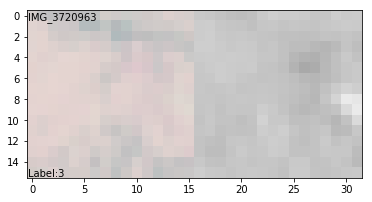

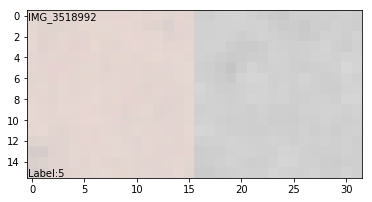

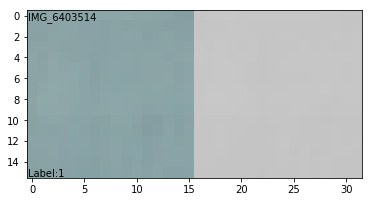

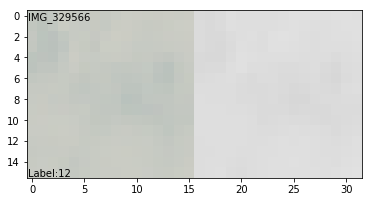

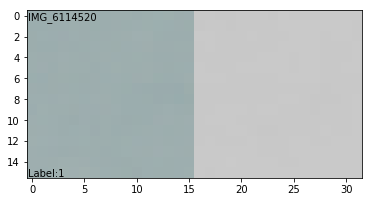

In [6]:
import random

NB_TESTS = 5
random_idxs = [random.choice(idxs) for x in range(NB_TESTS)]

for idx in random_idxs:
    display_img(PATH_DATA, idx, show_lbl=True, show_ir=True)

Désormais, maintenant que l'on sait afficher une image, on va chercher à afficher plusieurs patchs les uns à la suite des autres afin de connaître la corrélation entre les différents patchs:

In [11]:
import sys
from matplotlib.patches import Rectangle

col_lbl = []
col_lbl.append([170,240,240])
col_lbl.append([255,255,100])
col_lbl.append([220,240,100])
col_lbl.append([205,205,102])
col_lbl.append([  0,100,  0])
col_lbl.append([  0,160,  0])
col_lbl.append([170,200,  0])
col_lbl.append([  0, 60,  0])
col_lbl.append([ 40,100,  0])
col_lbl.append([120,130,  0])
col_lbl.append([140,160,  0])
col_lbl.append([190,150,  0])
col_lbl.append([150,100,  0])
col_lbl.append([255,180, 50])
col_lbl.append([255,235,175])
col_lbl.append([  0,120, 90])
col_lbl.append([  0,150,120])
col_lbl.append([  0,220,130])
col_lbl.append([195, 20,  0])
col_lbl.append([255,245,215])
col_lbl.append([  0, 70,200])
col_lbl.append([255,255,255])
col_lbl.append([  0,  0,  0])

def display_multiple_img(h5_path, m_idxs, show='rgb', size=4):
    """ Affiche une liste d'images """
    if show == 'ir':
        toolbar_width = 16
        progress = 0
        sys.stdout.write("Affichage en cours... [%s] %s %%" % (" " * toolbar_width, funky_print(0,100)))
        f = h5.File(h5_path, 'r')
        height = 16
        width  = 16
        final_height = 16*len(m_idxs)
        final_width  = 16*len(m_idxs[0])
        final_img = np.zeros((final_height, final_width, 3))
        count = 0
        for id_i in range(len(m_idxs)):
            progress += 1
            for id_j in range(len(m_idxs[0])):
                count += 1
                sys.stdout.write("\rAffichage en cours... [%s] %s %%" % ("#" * (progress*toolbar_width//len(m_idxs)) + " " * (toolbar_width-(progress*toolbar_width//len(m_idxs))), funky_print(int((count)/(m_idxs.shape[0]*m_idxs.shape[1])*100),100)))
                sys.stdout.flush()
                rgb8 = process_16bit_to_8bit(f['S2'][m_idxs[id_i,id_j],:,:,:])
                for i in range(len(rgb8)):
                    for j in range(len(rgb8[i])):
                        final_img[id_i*height+i,id_j*width+j,:] = [rgb8[i,j,3],rgb8[i,j,3],rgb8[i,j,3]]
        plt.figure(figsize=(size, size))
        plt.imshow(final_img)
        plt.text(final_width/(10*size),final_height/(5*size), 'IMG_%d' % m_idxs[0,0])
        plt.text(final_width/(10*size),final_height-final_height/(10*size), 'Size:%d/%d' % m_idxs.shape)
        plt.show()
    elif show == 'rgb':
        toolbar_width = 16
        progress = 0
        sys.stdout.write("Affichage en cours... [%s] %s %%" % (" " * toolbar_width, funky_print(0,100)))
        f = h5.File(h5_path, 'r')
        height = 16
        width  = 16
        final_height = 16*len(m_idxs)
        final_width  = 16*len(m_idxs[0])
        final_img = np.zeros((final_height, final_width, 3))
        count = 0
        for id_i in range(len(m_idxs)):
            progress += 1
            for id_j in range(len(m_idxs[0])):
                count += 1
                sys.stdout.write("\rAffichage en cours... [%s] %s %%" % ("#" * (progress*toolbar_width//len(m_idxs)) + " " * (toolbar_width-(progress*toolbar_width//len(m_idxs))), funky_print(int((count)/(m_idxs.shape[0]*m_idxs.shape[1])*100),100)))
                sys.stdout.flush()
                rgb8 = process_16bit_to_8bit(f['S2'][m_idxs[id_i,id_j],:,:,:])
                final_img[id_i*height:(id_i+1)*height,id_j*width:(id_j+1)*width,:] = rgb8[:,:,:3]
        plt.figure(figsize=(size, size))
        plt.imshow(final_img)
        plt.text(final_width/(10*size),final_height/(5*size), 'IMG_%d' % m_idxs[0,0])
        plt.text(final_width/(10*size),final_height-final_height/(10*size), 'Size:%d/%d' % m_idxs.shape)
        plt.show()
    elif show == 'lbl':
        toolbar_width = 16
        progress = 0
        sys.stdout.write("Affichage en cours... [%s] %s %%" % (" " * toolbar_width, funky_print(0,100)))
        f = h5.File(h5_path, 'r')
        height = 16
        width  = 16
        final_height = 16*len(m_idxs)
        final_width  = 16*len(m_idxs[0])
        final_img = np.zeros((final_height, final_width, 3))
        count = 0
        fig,ax = plt.subplots(1)
        fig.set_figheight(size)
        fig.set_figwidth(size)
        ax.imshow(final_img)
        for id_i in range(len(m_idxs)):
            progress += 1
            for id_j in range(len(m_idxs[0])):
                count += 1
                sys.stdout.write("\rAffichage en cours... [%s] %s %%" % ("#" * (progress*toolbar_width//len(m_idxs)) + " " * (toolbar_width-(progress*toolbar_width//len(m_idxs))), funky_print(int((count)/(m_idxs.shape[0]*m_idxs.shape[1])*100),100)))
                sys.stdout.flush()
                lbl = int(f['TOP_LANDCOVER'][m_idxs[id_i,id_j]][0])
                ax.add_patch(Rectangle((id_i*16, id_j*16), width = 16, height = 16, color=(col_lbl[lbl][0]/255, col_lbl[lbl][1]/255, col_lbl[lbl][2]/255)))
        plt.text(final_width/(10*size),final_height/(5*size), 'IMG_%d' % m_idxs[0,0])
        plt.text(final_width/(10*size),final_height-final_height/(10*size), 'Size:%d/%d' % m_idxs.shape)
        plt.show()

Affichage en cours... [################] 100 %

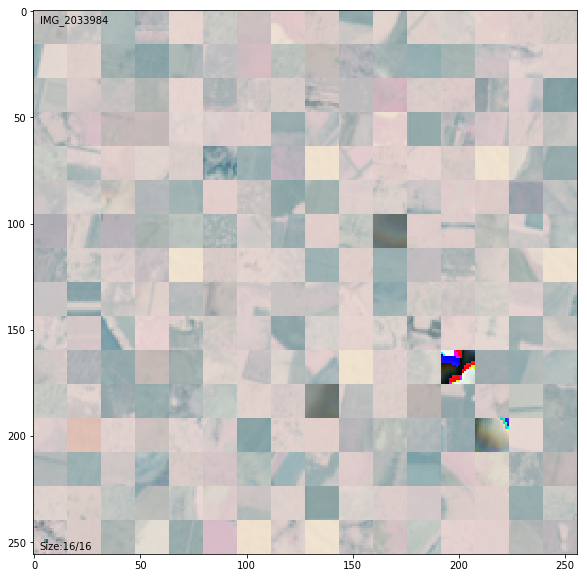

Affichage en cours... [################] 100 %

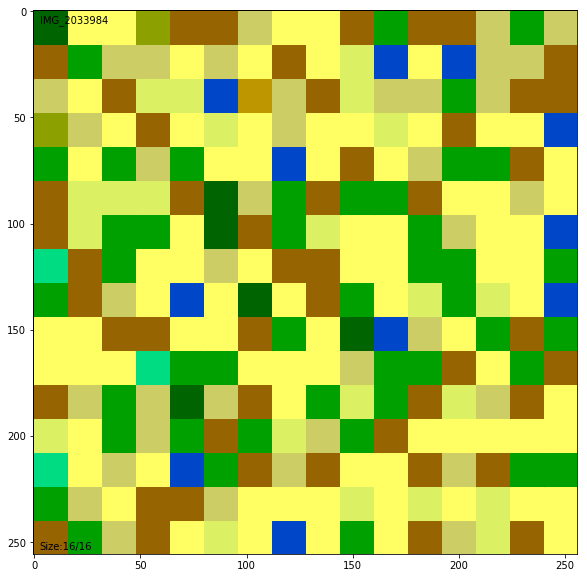

In [13]:
random_idxs = np.zeros((16,16))

for i in range(16):
    for j in range(16):
        random_idxs[i,j] = random.choice(idxs)

display_multiple_img(PATH_DATA, random_idxs, show = 'rgb', size=10)
display_multiple_img(PATH_DATA, random_idxs, show = 'lbl', size=10)

On cherche maintenant à afficher la totalité d'une image (_1024x1024_). On choisit donc un index aléatoire que l'on va modifier jusqu'à avoir l'image complète.

In [198]:
idx = random.choice(idxs)
print("RANDOM IDX : %d" % idx)

RANDOM IDX : 7609965


Affichage en cours... [################] 100 %

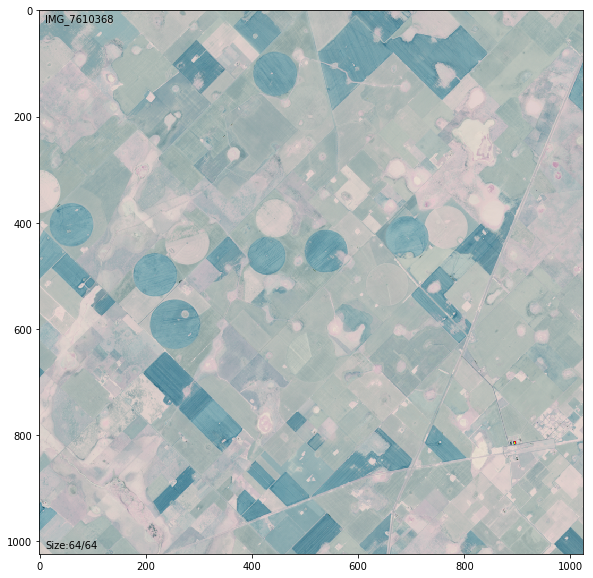

Affichage en cours... [################] 100 %

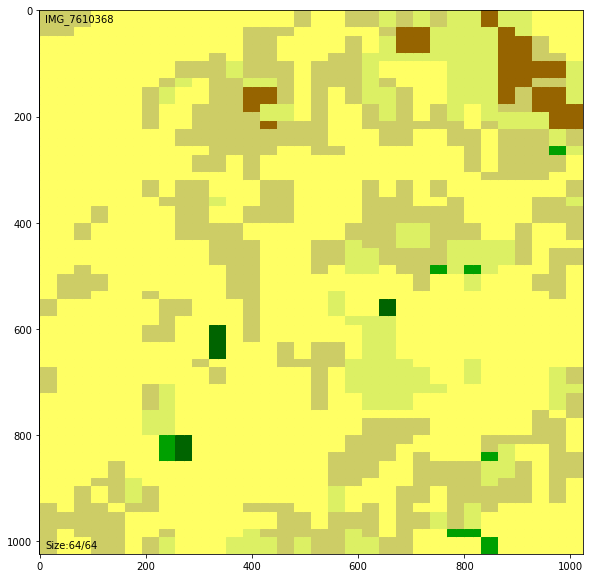

In [16]:
idx = 7609965
offset = 403
sample_idxs = np.zeros((64,64))

count = -1
for i in range(sample_idxs.shape[0]):
    for j in range(sample_idxs.shape[1]):
        count += 1
        sample_idxs[i,j] = idx + offset + count

display_multiple_img(PATH_DATA, sample_idxs, show = 'rgb', size=10)
#display_multiple_img(PATH_DATA, sample_idxs, show = 'ir', size=8)
display_multiple_img(PATH_DATA, sample_idxs, show = 'lbl', size=10)

# 3. Analyse des données à labelliser
Maintenant que tout ceci est fait on va s'intéresser aux données à labelliser. Pour ce faire, on charge les données et, comme précédemment, on affiche une image (_1024x1024_).

In [103]:
idx = random.choice(pred_idxs)
print("RANDOM IDX FROM PRED: %d" % idx)

RANDOM IDX FROM PRED: 174098


Affichage en cours... [################] 100 %

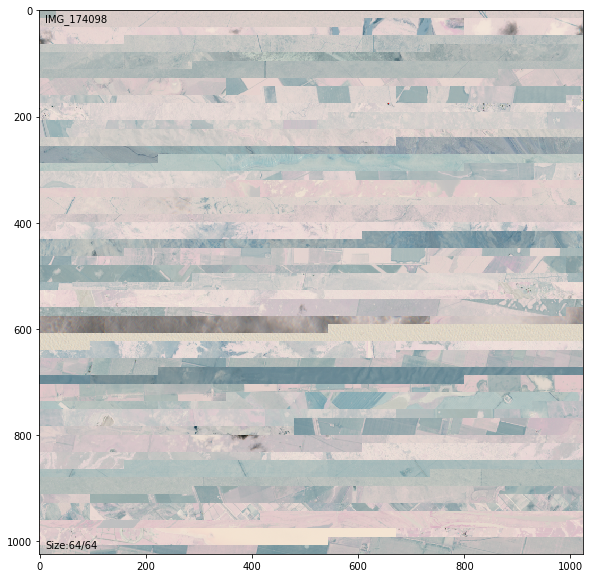

In [18]:
offset = 0
sample_idxs = np.zeros((64,64))
idx = 174098

count = -1
for i in range(sample_idxs.shape[0]):
    for j in range(sample_idxs.shape[1]):
        count += 1
        sample_idxs[i,j] = idx + offset + count

display_multiple_img(PATH_PREDICT_WITHOUT_GT, sample_idxs, show = 'rgb', size=10)

Une première analyse montre qu'un tirage aléatoire est effectuée sur les patchs. Malgré tout, on discerne des régions: les patchs ne sont pas décorrélés les uns des autres, on observe des séquences d'images qui se suivent.

Un traitement sur une image (_1024x1024_), même si il avait été possible de le faire, est inutile. Néanmoins, on peut observer une corrélation des images en ligne et il serait intéressant de rendre compte de ce phénomène.

# 4. Etude de la corrélation

On se propose donc d'étudier la corrélation entre les patchs qui se suivent. Tout d'abord, l'étude se concentrera sur la corrélation des patchs de _half.h5_. Ainsi, on crée un liste qui va agir comme une version compressée des labels du jeu de données. La liste sera constituée d'un succession de 2 entiers:
- **premier entier**: représente la classe du patch
- **second entier**: nombre de patchs successifs ayant le même label

### ATTENTION ! NE PAS LANCER LE CODE CI-DESSOUS SAUF SI VOUS AVEZ DU TEMPS DEVANT VOUS

In [284]:
f = h5.File(PATH_DATA, 'r')

count = 1
n = len(idxs)

lbl_list = []
tmp_lbl = -1
tmp_count = 1
print('>>> %s / %d | length: %s | current:[lbl, %snb ]' % (" " * len(str(n)), n, " " * len(str(n)), " " * (len(str(1000000))-2)))
for idx in idxs:
    lbl = f['TOP_LANDCOVER'][idx][0].astype('uint8')
    if lbl != tmp_lbl:
        tmp_lbl = lbl
        tmp_count = 0
        lbl_list.append([tmp_lbl, tmp_count])
    tmp_count += 1
    lbl_list[-1][1] = tmp_count
    if (count%10000 == 0):
        print('>>> %s / %d | length: %s | current:[ %s, %s ]' % (funky_print(count, n), n, funky_print(len(lbl_list),n), funky_print(tmp_lbl,23), funky_print(tmp_count,1000000)))
    count+=1

>>>         / 9349120 | length:         | current:[lbl,      nb ]
>>>   10000 / 9349120 | length:       1 | current:[ 20,   10000 ]
>>>   20000 / 9349120 | length:       1 | current:[ 20,   20000 ]
>>>   30000 / 9349120 | length:       1 | current:[ 20,   30000 ]
>>>   40000 / 9349120 | length:       1 | current:[ 20,   40000 ]
>>>   50000 / 9349120 | length:       1 | current:[ 20,   50000 ]
>>>   60000 / 9349120 | length:       1 | current:[ 20,   60000 ]
>>>   70000 / 9349120 | length:       1 | current:[ 20,   70000 ]
>>>   80000 / 9349120 | length:       1 | current:[ 20,   80000 ]
>>>   90000 / 9349120 | length:       1 | current:[ 20,   90000 ]
>>>  100000 / 9349120 | length:       1 | current:[ 20,  100000 ]
>>>  110000 / 9349120 | length:       1 | current:[ 20,  110000 ]
>>>  120000 / 9349120 | length:       1 | current:[ 20,  120000 ]
>>>  130000 / 9349120 | length:       1 | current:[ 20,  130000 ]
>>>  140000 / 9349120 | length:       1 | current:[ 20,  140000 ]
>>>  15000

>>> 1250000 / 9349120 | length:  140335 | current:[  5,       2 ]
>>> 1260000 / 9349120 | length:  141518 | current:[  5,      14 ]
>>> 1270000 / 9349120 | length:  142146 | current:[  4,       8 ]
>>> 1280000 / 9349120 | length:  143472 | current:[ 12,       2 ]
>>> 1290000 / 9349120 | length:  144150 | current:[  4,      11 ]
>>> 1300000 / 9349120 | length:  145460 | current:[  3,      10 ]
>>> 1310000 / 9349120 | length:  146656 | current:[  5,      33 ]
>>> 1320000 / 9349120 | length:  147861 | current:[  3,       2 ]
>>> 1330000 / 9349120 | length:  149430 | current:[  5,       4 ]
>>> 1340000 / 9349120 | length:  150807 | current:[  5,       6 ]
>>> 1350000 / 9349120 | length:  152647 | current:[  2,       1 ]
>>> 1360000 / 9349120 | length:  154622 | current:[  5,       3 ]
>>> 1370000 / 9349120 | length:  156207 | current:[  4,      19 ]
>>> 1380000 / 9349120 | length:  158225 | current:[  2,       6 ]
>>> 1390000 / 9349120 | length:  159905 | current:[  5,       2 ]
>>> 140000

>>> 2500000 / 9349120 | length:  354065 | current:[ 12,     196 ]
>>> 2510000 / 9349120 | length:  354437 | current:[ 12,     153 ]
>>> 2520000 / 9349120 | length:  355709 | current:[  5,       3 ]
>>> 2530000 / 9349120 | length:  357349 | current:[ 12,       3 ]
>>> 2540000 / 9349120 | length:  358484 | current:[  1,       6 ]
>>> 2550000 / 9349120 | length:  360137 | current:[  1,       2 ]
>>> 2560000 / 9349120 | length:  361607 | current:[  3,       7 ]
>>> 2570000 / 9349120 | length:  363586 | current:[ 12,       5 ]
>>> 2580000 / 9349120 | length:  365560 | current:[ 17,       6 ]
>>> 2590000 / 9349120 | length:  367217 | current:[  1,       2 ]
>>> 2600000 / 9349120 | length:  368879 | current:[  1,       3 ]
>>> 2610000 / 9349120 | length:  370686 | current:[  2,       3 ]
>>> 2620000 / 9349120 | length:  372945 | current:[ 12,       2 ]
>>> 2630000 / 9349120 | length:  374839 | current:[  1,       5 ]
>>> 2640000 / 9349120 | length:  376768 | current:[  3,      38 ]
>>> 265000

>>> 3750000 / 9349120 | length:  473071 | current:[  5,      46 ]
>>> 3760000 / 9349120 | length:  473922 | current:[  3,       2 ]
>>> 3770000 / 9349120 | length:  475315 | current:[  3,       6 ]
>>> 3780000 / 9349120 | length:  477421 | current:[  3,       8 ]
>>> 3790000 / 9349120 | length:  479087 | current:[ 12,       1 ]
>>> 3800000 / 9349120 | length:  480459 | current:[ 12,       2 ]
>>> 3810000 / 9349120 | length:  481964 | current:[ 12,       4 ]
>>> 3820000 / 9349120 | length:  483052 | current:[ 12,       2 ]
>>> 3830000 / 9349120 | length:  483527 | current:[ 12,      14 ]
>>> 3840000 / 9349120 | length:  484206 | current:[ 12,       8 ]
>>> 3850000 / 9349120 | length:  484580 | current:[ 12,     570 ]
>>> 3860000 / 9349120 | length:  485422 | current:[ 12,       7 ]
>>> 3870000 / 9349120 | length:  486295 | current:[  3,       3 ]
>>> 3880000 / 9349120 | length:  487343 | current:[ 12,      20 ]
>>> 3890000 / 9349120 | length:  488426 | current:[ 12,       1 ]
>>> 390000

>>> 5000000 / 9349120 | length:  580138 | current:[ 12,       5 ]
>>> 5010000 / 9349120 | length:  581539 | current:[ 12,       4 ]
>>> 5020000 / 9349120 | length:  583627 | current:[  3,       3 ]
>>> 5030000 / 9349120 | length:  585546 | current:[ 20,      11 ]
>>> 5040000 / 9349120 | length:  586842 | current:[  3,       3 ]
>>> 5050000 / 9349120 | length:  588340 | current:[  5,       6 ]
>>> 5060000 / 9349120 | length:  590031 | current:[ 12,       1 ]
>>> 5070000 / 9349120 | length:  590616 | current:[ 12,       8 ]
>>> 5080000 / 9349120 | length:  591657 | current:[  5,       5 ]
>>> 5090000 / 9349120 | length:  593038 | current:[  5,       9 ]
>>> 5100000 / 9349120 | length:  594765 | current:[ 12,      27 ]
>>> 5110000 / 9349120 | length:  595871 | current:[  3,       3 ]
>>> 5120000 / 9349120 | length:  597578 | current:[ 12,       5 ]
>>> 5130000 / 9349120 | length:  598456 | current:[ 12,       1 ]
>>> 5140000 / 9349120 | length:  600148 | current:[  3,       3 ]
>>> 515000

>>> 6250000 / 9349120 | length:  767164 | current:[  1,      14 ]
>>> 6260000 / 9349120 | length:  769039 | current:[  3,       2 ]
>>> 6270000 / 9349120 | length:  770219 | current:[  1,      24 ]
>>> 6280000 / 9349120 | length:  770715 | current:[  1,       7 ]
>>> 6290000 / 9349120 | length:  771739 | current:[  1,       6 ]
>>> 6300000 / 9349120 | length:  773012 | current:[  1,      30 ]
>>> 6310000 / 9349120 | length:  774053 | current:[  1,       5 ]
>>> 6320000 / 9349120 | length:  774571 | current:[  1,      25 ]
>>> 6330000 / 9349120 | length:  775744 | current:[  1,       8 ]
>>> 6340000 / 9349120 | length:  776620 | current:[  1,       6 ]
>>> 6350000 / 9349120 | length:  777397 | current:[  1,     117 ]
>>> 6360000 / 9349120 | length:  778157 | current:[  3,       2 ]
>>> 6370000 / 9349120 | length:  779353 | current:[  1,      36 ]
>>> 6380000 / 9349120 | length:  780484 | current:[  1,       6 ]
>>> 6390000 / 9349120 | length:  781295 | current:[  1,     259 ]
>>> 640000

>>> 7500000 / 9349120 | length:  900067 | current:[  1,       1 ]
>>> 7510000 / 9349120 | length:  901479 | current:[  1,     221 ]
>>> 7520000 / 9349120 | length:  902379 | current:[  1,      16 ]
>>> 7530000 / 9349120 | length:  903854 | current:[  3,       1 ]
>>> 7540000 / 9349120 | length:  905152 | current:[  1,      32 ]
>>> 7550000 / 9349120 | length:  906134 | current:[  1,     331 ]
>>> 7560000 / 9349120 | length:  907429 | current:[  1,       5 ]
>>> 7570000 / 9349120 | length:  908394 | current:[  1,       4 ]
>>> 7580000 / 9349120 | length:  910204 | current:[  3,       2 ]
>>> 7590000 / 9349120 | length:  911728 | current:[  1,       7 ]
>>> 7600000 / 9349120 | length:  913011 | current:[  1,      22 ]
>>> 7610000 / 9349120 | length:  914667 | current:[  1,       4 ]
>>> 7620000 / 9349120 | length:  916562 | current:[  1,       2 ]
>>> 7630000 / 9349120 | length:  918258 | current:[  3,       3 ]
>>> 7640000 / 9349120 | length:  919227 | current:[  1,     373 ]
>>> 765000

>>> 8750000 / 9349120 | length: 1083554 | current:[  1,      10 ]
>>> 8760000 / 9349120 | length: 1084428 | current:[  1,    1196 ]
>>> 8770000 / 9349120 | length: 1085299 | current:[  1,      16 ]
>>> 8780000 / 9349120 | length: 1086513 | current:[  2,       1 ]
>>> 8790000 / 9349120 | length: 1087729 | current:[  3,      10 ]
>>> 8800000 / 9349120 | length: 1088576 | current:[  1,    1840 ]
>>> 8810000 / 9349120 | length: 1089220 | current:[  1,      15 ]
>>> 8820000 / 9349120 | length: 1090441 | current:[  2,       6 ]
>>> 8830000 / 9349120 | length: 1091690 | current:[  3,       5 ]
>>> 8840000 / 9349120 | length: 1093226 | current:[  1,     507 ]
>>> 8850000 / 9349120 | length: 1094314 | current:[  1,       5 ]
>>> 8860000 / 9349120 | length: 1095558 | current:[  1,       4 ]
>>> 8870000 / 9349120 | length: 1096423 | current:[  1,      24 ]
>>> 8880000 / 9349120 | length: 1098026 | current:[  2,       2 ]
>>> 8890000 / 9349120 | length: 1099043 | current:[  2,       1 ]
>>> 890000

On enregistre la liste dans un fichier afin de le réutiliser plus tard. 

In [287]:
#np.savetxt('lbl_list_1.csv', np.asarray(lbl_list), delimiter=',')

Maintenant que nous avons créé cette liste, il ne reste plus qu'à compter les transitions et ainsi construire une matrice de transition entre patchs. On commence par charger la liste des labels qu'on vient d'enregistrer.

In [19]:
lbl_array = np.genfromtxt('lbl_list_1.csv', delimiter=',')

In [20]:
transition_matrix = np.zeros((23,23))

progress = 0
toolbar_width = 16

for i in range(len(lbl_array)):
    [lbl, count] = lbl_array[i][:]
    [p_lbl, p_count] = lbl_array[i-1][:]
    lbl = int(lbl)
    p_lbl = int(p_lbl)
    transition_matrix[lbl,lbl] += count -1
    transition_matrix[lbl,p_lbl] += 1
    transition_matrix[p_lbl,lbl] += 1

In [302]:
#np.savetxt('transition_matrix_1.csv', transition_matrix, delimiter=',')

La matrice de transition contient désormais le nombre de transitions existantes entre chacune des classes. Afin de pouvoir l'utiliser, l'on va normaliser chaque ligne de telle sorte que la somme de chaque ligne égale 1. Or, il se peut que des classes soient totalement absentes de la base de données. Pour palier à ce problème, on pose l'hypothèse que la transition partant d'une classe initialement absente du jeu de données a autant de chance de s'effectuer vers chaque autre classe.

In [21]:
for i in range(23):
    line_sum = sum(transition_matrix[i])
    if line_sum == 0:
        for j in range(23):
            transition_matrix[i,j] = 1/23
    else:
        for j in range(23):
            transition_matrix[i,j] = transition_matrix[i,j]/line_sum

for i in range(23):
    line = "[ "
    for j in range(23):
        line += funky_print(int(transition_matrix[i,j]*100),100)
        line += " "
    line += " ]"
    if i == 22:
        line += " %"
    print(line)

[   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4  ]
[   0  86   4   8   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  ]
[   0  12  56  19   1   2   0   0   0   0   0   0   6   0   0   0   0   0   0   0   0   0   0  ]
[   0  12  10  64   0   1   0   0   0   0   0   0   9   0   0   0   0   0   0   0   0   0   0  ]
[   0   0   4   2  72  13   0   0   0   0   0   0   5   0   0   0   0   0   0   0   0   0   0  ]
[   0   0   1   1   1  89   0   0   0   0   0   0   5   0   0   0   0   0   0   0   0   0   0  ]
[   0  20  17  17   0   0  41   0   0   0   0   0   2   0   0   0   0   0   0   0   0   0   0  ]
[   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4  ]
[   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4  ]
[   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4  ]
[   0   7   1  16   0   0   0 

# 5. Application au jeu de données

Afin de mettre en application cette matrice de transition, on choisit de faire une prédiction à 1 niveau. Pour analyser la probabilité qu'un patch soit d'une classe donnée, on regarde le vecteur de probabilité des patchs précédent et suivant et, grâce à la matrice de transition, on retourne le vecteur de probabilité du patch courant.

In [22]:
def compute_proba(transition_matrix, p_output, n_output):
    """ Calcule la probabilité de la classe du patch situé entre p_output et n_output """
    prob_from_p = transition_matrix.transpose().dot(p_output)
    prob_from_n = transition_matrix.transpose().dot(n_output)
    return (prob_from_p + prob_from_n)/2

## 5.1 Chargement du CNN
On charge un modèle de prédiction et on va observer l'effet de l'application du correctif.

In [23]:
!pip  install keras

    100% |################################| 337kB 3.1MB/s ta 0:00:01
    100% |################################| 256kB 4.0MB/s ta 0:00:011
  Running setup.py bdist_wheel for pyyaml ... done
  Stored in directory: /root/.cache/pip/wheels/2c/f7/79/13f3a12cd723892437c0cfbde1230ab4d82947ff7b3839a4fc
Successfully built pyyaml
You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [24]:
from keras.models import load_model
model = load_model("../5tars-and-a-friend/awesome_model_full_beast_fucking_mode.dqf")

Using TensorFlow backend.


In [25]:
def get_batch_count(idxs, batch_size):
    batch_count = int(len(idxs)//batch_size)
    remained_samples = len(idxs)%batch_size
    if remained_samples > 0:
        batch_count += 1
    return batch_count

In [26]:
import os

BATCH_SIZE=32

def prediction_generator(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')
    batch_count = get_batch_count(idxs, batch_size)
    for b in range(batch_count):
        batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
        batch_idxs = sorted(batch_idxs)
        X = f['S2'][batch_idxs, :,:,:]
        yield np.array(X)

def build_h5_pred_file(pred, h5_output_path):
    if os.path.exists(h5_output_path):
        os.remove(h5_output_path)
    f = h5.File(h5_output_path, 'w')
    top_landcover_submit = f.create_dataset("TOP_LANDCOVER", (len(pred), 1), maxshape=(None, 1))
    top_landcover_submit[:, 0] = pred
    f.close()
    return 1

## 5.2 Prédiction du CNN
### 5.2.1 Premier essai

On lance la prédiction sur un jeu de données:

In [27]:
import pandas as pd

pred_idx = get_idxs(PATH_PREDICT_WITHOUT_GT)
print('Nombre de patchs à prédire: %d' % len(pred_idx))
pred_gen = prediction_generator(PATH_PREDICT_WITHOUT_GT, BATCH_SIZE, pred_idx)
prediction = model.predict_generator(pred_gen, steps=get_batch_count(pred_idx, BATCH_SIZE), verbose=1)
print('Nombre de vecteurs de prédiction: %d' % len(prediction))
y_pred = np.argmax(prediction, axis = 1)

PATH_SUBMIT = 'final_prediction_6_without_transition.csv'
df = pd.DataFrame(y_pred, columns=['TOP_LANDCOVER'])
df.to_csv(PATH_SUBMIT, index_label="ID")

Nombre de patchs à prédire: 241700
7554/7554 [==============================] - 55s 7ms/step
Nombre de vecteurs de prédiction: 241700


In [28]:
compute_prediction = np.zeros((len(prediction), 23))
current_pred = np.zeros((23,1))
compute_pred = np.zeros((23,1))

count_diff = 0
toolbar_width = 16
sys.stdout.write("Nostradamus prédit... [%s] %s/%d" % (" " * toolbar_width, funky_print(0, len(prediction)), len(prediction)))
for k in range(len(prediction)):
    current_pred[:] = prediction[k].reshape(23,1)[:]
    if k == len(prediction)-1:
        compute_pred[:] = compute_proba(transition_matrix, prediction[k-1].reshape(23,1), prediction[0].reshape(23,1))[:]
    else:
        compute_pred[:] = compute_proba(transition_matrix, prediction[k-1].reshape(23,1), prediction[k+1].reshape(23,1))[:]
    if int(np.argmax(current_pred)) != int(np.argmax(compute_pred)):
        count_diff += 1
    if k%1000 == 0:
        sys.stdout.write("\rNostradamus prédit... [%s] %s/%d" % ("#" * (k*toolbar_width//len(prediction)) + " " * (toolbar_width-(k*toolbar_width//len(prediction))), funky_print(k, len(prediction)), len(prediction)))
        sys.stdout.flush()
    compute_prediction[k,:] = compute_pred.reshape(23)[:]
sys.stdout.write("\rNostradamus prédit... [%s] %s/%d | diff: %d" % ("#" * toolbar_width, funky_print(len(prediction), len(prediction)), len(prediction), count_diff))
sys.stdout.flush()

Nostradamus prédit... [################] 241700/241700 | diff: 49501

In [29]:
print("DIFFERENCE DE PREDICTION : %d" % count_diff)

DIFFERENCE DE PREDICTION : 49501


In [30]:
idx = np.random.choice(pred_idx)

current_pred = prediction[idx].reshape(23,1)
compute_pred = compute_proba(transition_matrix, prediction[idx-1].reshape(23,1), prediction[idx+1].reshape(23,1))

for i in range(23):
    line = "[ "
    line += funky_print(int(current_pred[i]*100),100)
    line += " | "
    line += funky_print(int(compute_pred[i]*100),100)
    line += " ]"
    if i == 22:
        line += " idx:"
        line += str(idx)
        line += " | "
        line += str(sum(current_pred)[0])
    print(line)
line = "[=====|=====]"
print(line)
line = "[ "
line += funky_print(int(np.argmax(current_pred)),100)
line += " | "
line += funky_print(int(np.argmax(compute_pred)),100)
line += " ]"
print(line)
line = "[ "
line += funky_print(int(max(current_pred)*100),100)
line += " | "
line += funky_print(int(max(compute_pred)*100),100)
line += " ]"
print(line)

[   0 |   0 ]
[   0 |   6 ]
[   0 |   5 ]
[   1 |  10 ]
[   0 |   3 ]
[   0 |   5 ]
[   0 |   0 ]
[   0 |   0 ]
[   0 |   0 ]
[   0 |   0 ]
[   4 |   5 ]
[  28 |   5 ]
[  38 |  40 ]
[   0 |   0 ]
[  17 |   5 ]
[   0 |   0 ]
[   0 |   0 ]
[   0 |   1 ]
[   0 |   0 ]
[   4 |   1 ]
[   0 |   4 ]
[   0 |   0 ]
[   0 |   0 ] idx:85351 | 1.0
[=====|=====]
[  12 |  12 ]
[  38 |  40 ]


Maintenant, il s'agit de sortir les labels. Il faut trancher: faire entièrement confiance au CNN, faire entièrement confiance à la matrice de transition.

In [31]:
final_prediction = [0 for i in range(len(prediction))]

count = 0
for k in range(len(prediction)):
    argmax_pred = np.argmax(prediction[k])
    max_pred = max(prediction[k])
    argmax_compute_pred = np.argmax(compute_prediction[k])
    max_compute_pred = max(compute_prediction[k])
    if argmax_pred != argmax_compute_pred and max_compute_pred > max_pred:
        count += 1
        final_prediction[k] = int(argmax_compute_pred)
    else:
        final_prediction[k] = int(argmax_pred)

print("CHANGEMENTS: %d" % count)

CHANGEMENTS: 21093


In [32]:
import pandas as pd
PATH_SUBMIT = 'final_prediction_6_with_transition_v0.csv'
df = pd.DataFrame(final_prediction, columns=['TOP_LANDCOVER'])
df.to_csv(PATH_SUBMIT, index_label="ID")

### 5.2.2 Deuxième essai

On va changer la méthode de calcul et on va prendre en compte dans le calcul de la sortie du CNN.

In [33]:
def compute_proba_3(transition_matrix, p_output, c_output, n_output):
    """ Calcule la probabilité de la classe de c_output situé entre p_output et n_output """
    prob_from_p = transition_matrix.transpose().dot(p_output)
    prob_from_n = transition_matrix.transpose().dot(n_output)
    return (prob_from_p + c_output + prob_from_n)/3

In [34]:
compute_prediction_3 = np.zeros((len(prediction), 23))
current_pred = np.zeros((23,1))
compute_pred = np.zeros((23,1))
idx_change = []

epoch = 1

i = 0
while i < epoch:
    i += 1
    count_diff = 0
    toolbar_width = 16
    sys.stdout.write("Nostradamus prédit... epoch %s/%d [%s] %s/%d" % (funky_print(i, epoch), epoch, " " * toolbar_width, funky_print(0, len(prediction)), len(prediction)))
    sys.stdout.flush()
    for k in range(len(prediction)):
        current_pred[:] = prediction[k].reshape(23,1)[:]
        if k == len(prediction)-1:
            compute_pred[:] = compute_proba_3(transition_matrix, prediction[k-1].reshape(23,1), prediction[k].reshape(23,1), prediction[0].reshape(23,1))[:]
        else:
            compute_pred[:] = compute_proba_3(transition_matrix, prediction[k-1].reshape(23,1), prediction[k].reshape(23,1), prediction[k+1].reshape(23,1))[:]
        if int(np.argmax(current_pred)) != int(np.argmax(compute_pred)):
            count_diff += 1
            idx_change.append(k)
        if k%1000 == 0:
            sys.stdout.write("\rNostradamus prédit... epoch %s/%d [%s] %s/%d" % (funky_print(i, epoch), epoch, "#" * (k*toolbar_width//len(prediction)) + " " * (toolbar_width-(k*toolbar_width//len(prediction))), funky_print(k, len(prediction)), len(prediction)))
            sys.stdout.flush()
        compute_prediction_3[k,:] = compute_pred.reshape(23)[:]
    sys.stdout.write("\rNostradamus prédit... epoch %s/%d [%s] %s/%d | diff: %d" % (funky_print(i, epoch), epoch, "#" * toolbar_width, funky_print(len(prediction), len(prediction)), len(prediction), count_diff))
    sys.stdout.flush()
    print("")
    if epoch != 1:
        prediction[:,:] = compute_prediction_3[:,:]

Nostradamus prédit... epoch 1/1 [################] 241700/241700 | diff: 33755


Affichage en cours... [################] 100 %

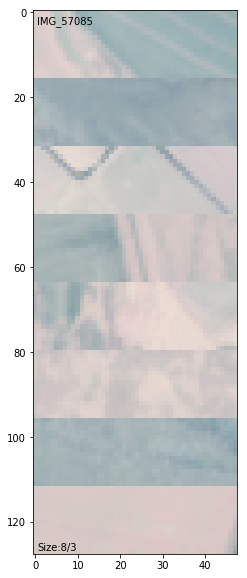

In [37]:
NB_TESTS = 8
random_idxs = [random.choice(idx_change) for x in range(NB_TESTS)]

#for idx in random_idxs:
    #display_img(PATH_PREDICT_WITHOUT_GT, idx, show_lbl=False, show_ir=True)
    #print("INIT: %d | NEW: %d" % (int(np.argmax(prediction[idx])),int(np.argmax(compute_prediction_3[idx]))))
    
sample_idxs = np.zeros((NB_TESTS,3))

count = -1
for i in range(sample_idxs.shape[0]):
    for j in range(sample_idxs.shape[1]):
        count += 1
        sample_idxs[i,j] = random_idxs[i] + j - 1

display_multiple_img(PATH_PREDICT_WITHOUT_GT, sample_idxs, show = 'rgb', size=10)

In [38]:
final_prediction_3 = [0 for i in range(len(prediction))]

for k in range(len(prediction)):
    final_prediction_3[k] = int(np.argmax(compute_prediction_3[k]))

In [39]:
import pandas as pd
PATH_SUBMIT = 'final_prediction_final_beast.csv'
df = pd.DataFrame(final_prediction_3, columns=['TOP_LANDCOVER'])
df.to_csv(PATH_SUBMIT, index_label="ID")

### 5.2.3 Troisième essai

In [40]:
compute_prediction = np.zeros((len(prediction), 23))
current_pred = np.zeros((23,1))
compute_pred = np.zeros((23,1))

count_diff = 0
toolbar_width = 16
sys.stdout.write("Nostradamus prédit... [%s] %s/%d" % (" " * toolbar_width, funky_print(0, len(prediction)), len(prediction)))
for k in range(len(prediction)):
    current_pred[:] = prediction[k].reshape(23,1)[:]
    if k == len(prediction)-1:
        compute_pred[:] = compute_proba(transition_matrix, prediction[k-1].reshape(23,1), prediction[0].reshape(23,1))[:]
    else:
        compute_pred[:] = compute_proba(transition_matrix, prediction[k-1].reshape(23,1), prediction[k+1].reshape(23,1))[:]
    compute_pred[:] = compute_pred[:]*current_pred[:]
    if int(np.argmax(current_pred)) != int(np.argmax(compute_pred)):
        count_diff += 1
    if k%1000 == 0:
        sys.stdout.write("\rNostradamus prédit... [%s] %s/%d" % ("#" * (k*toolbar_width//len(prediction)) + " " * (toolbar_width-(k*toolbar_width//len(prediction))), funky_print(k, len(prediction)), len(prediction)))
        sys.stdout.flush()
    compute_prediction[k,:] = compute_pred.reshape(23)[:]
sys.stdout.write("\rNostradamus prédit... [%s] %s/%d | diff: %d" % ("#" * toolbar_width, funky_print(len(prediction), len(prediction)), len(prediction), count_diff))
sys.stdout.flush()

Nostradamus prédit... [################] 241700/241700 | diff: 27148

In [41]:
final_prediction = [0 for i in range(len(prediction))]

for k in range(len(prediction)):
    final_prediction[k] = int(np.argmax(compute_prediction[k]))

In [42]:
import pandas as pd
PATH_SUBMIT = 'final_prediction_6_with_transition_v2.csv'
df = pd.DataFrame(final_prediction, columns=['TOP_LANDCOVER'])
df.to_csv(PATH_SUBMIT, index_label="ID")

## 5.3 Découpage de la base de données en régions

Il serait intelligent de trier la base de données en régions de manière à appliquer convenablement la matrice de transition.

Pour ce faire, on va entraîner un CNN pour détecter les coupes spatiales. Tout d'abord, il faut créer la base d'entrainement.

Affichage en cours... [################] 100 %

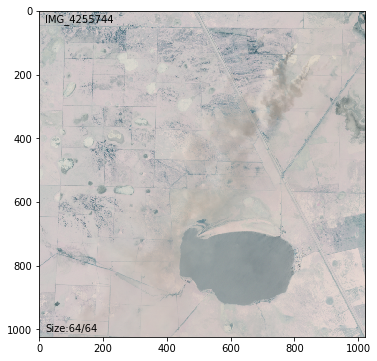

Affichage en cours... [################] 100 %

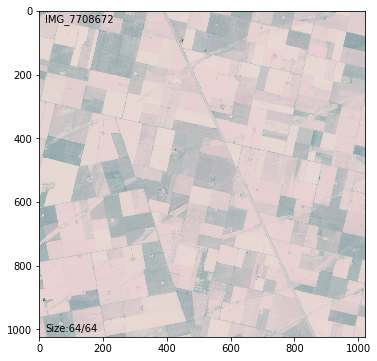

Affichage en cours... [################] 100 %

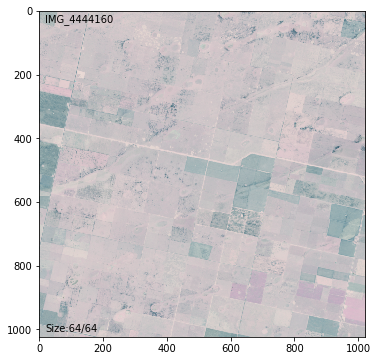

In [54]:
idx = 4096*random.choice(range(2200))
sample_idxs = np.zeros((64,64))

count = -1
for i in range(sample_idxs.shape[0]):
    for j in range(sample_idxs.shape[1]):
        count += 1
        sample_idxs[i,j] = idx + offset + count

display_multiple_img(PATH_DATA, sample_idxs, show = 'rgb', size=6)

idx = 4096*random.choice(range(2200))
sample_idxs = np.zeros((64,64))

count = -1
for i in range(sample_idxs.shape[0]):
    for j in range(sample_idxs.shape[1]):
        count += 1
        sample_idxs[i,j] = idx + offset + count

display_multiple_img(PATH_DATA, sample_idxs, show = 'rgb', size=6)

idx = 4096*random.choice(range(2200))
sample_idxs = np.zeros((64,64))

count = -1
for i in range(sample_idxs.shape[0]):
    for j in range(sample_idxs.shape[1]):
        count += 1
        sample_idxs[i,j] = idx + offset + count

display_multiple_img(PATH_DATA, sample_idxs, show = 'rgb', size=6)

In [60]:
def split_train_val(sample_idxs, proportion):
    n_samples = len(sample_idxs)
    return sample_idxs[:int((1.-proportion)*n_samples)], sample_idxs[int((1.-proportion)*n_samples):]

idxs_subsample = [[64*(x+1)-1, 64*(x+1)] for x in range(140800)]
for x in range(140800):
    y = random.randint(1,64)
    idxs_subsample = idxs_subsample + [[64*(x+1)+(y-1), 64*(x+1)+y]]

In [83]:
def shuffle_idx(sample_idxs):
    return list(np.random.permutation(sample_idxs))

def split_train_val(sample_idxs, proportion):
    n_samples = len(sample_idxs)
    return sample_idxs[:int((1.-proportion)*n_samples)], sample_idxs[int((1.-proportion)*n_samples):]

def get_batch_count(idxs, batch_size):
    batch_count = int(len(idxs)//batch_size)
    remained_samples = len(idxs)%batch_size
    if remained_samples > 0:
        batch_count += 1

    return batch_count

def to_array(h5_path, idx_1, idx_2):
    f = h5.File(h5_path, 'r')
    X_1 = f['S2'][idx_1, :,:,:]
    X_2 = f['S2'][idx_2, :,:,:]
    result = np.zeros((16,32,4))
    result[:,:16,:] = X_1[:,:,:]
    result[:,16:,:] = X_2[:,:,:]
    return result

In [65]:
shuffled_idxs = shuffle_idx(idxs_subsample)
train_idxs, val_idxs = split_train_val(shuffled_idxs, 0.2)

In [97]:
def generator(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')
    while True : 
        idxs = shuffle_idx(idxs)
        batch_count = get_batch_count(idxs, batch_size)
        for b in range(batch_count):
            batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
            X = np.zeros((len(batch_idxs),16,32,4))
            Y = np.zeros((len(batch_idxs)))
            for i in range(len(batch_idxs)):
                X[i,:,:,:] = to_array(h5_path, batch_idxs[i][0], batch_idxs[i][1])[:,:,:]
                if batch_idxs[i][1]%64==0:
                    Y[i] = 1
                else:
                    Y[i] = 0
            yield X, keras.utils.np_utils.to_categorical(Y, 2)

In [98]:
train_gen = generator(PATH_DATA, BATCH_SIZE, train_idxs)
train_batch_count = get_batch_count(train_idxs, BATCH_SIZE)

val_gen = generator(PATH_DATA, BATCH_SIZE, val_idxs)
val_batch_count = get_batch_count(val_idxs, BATCH_SIZE)

In [99]:
from keras.models import Model
from keras.layers import Input, Conv3D, Conv2D, Dropout, MaxPooling2D, Flatten, Activation, AveragePooling2D, ZeroPadding2D

input_shape = (16,32,4)
dropout_rate = 0.5

model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=input_shape))
model.add(Conv2D(4,(3,3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(4, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(2, activation='softmax'))

In [100]:
# optim = keras.optimizers.Adam(lr=0.001)
optim = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

model.compile(optimizer=optim,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit_generator(train_gen, steps_per_epoch=50, epochs=10, verbose=1, validation_data=val_gen, nb_val_samples=100)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=1, validation_data=<generator..., steps_per_epoch=50, epochs=10, validation_steps=100)`
  


Epoch 1/10
 2/50 [>.............................] - ETA: 11:49 - loss: 5.6392 - acc: 0.4609

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.288188). Check your callbacks.
  % delta_t_median)


 3/50 [>.............................] - ETA: 8:00 - loss: 5.8601 - acc: 0.4375 

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.375117). Check your callbacks.
  % delta_t_median)


 4/50 [=>............................] - ETA: 6:23 - loss: 5.7397 - acc: 0.4414

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.302364). Check your callbacks.
  % delta_t_median)


 6/50 [==>...........................] - ETA: 5:50 - loss: 5.2289 - acc: 0.4635

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.420131). Check your callbacks.
  % delta_t_median)


 8/50 [===>..........................] - ETA: 5:24 - loss: 4.8289 - acc: 0.4922

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.348645). Check your callbacks.
  % delta_t_median)


 9/50 [====>.........................] - ETA: 5:14 - loss: 4.7512 - acc: 0.4965

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.322174). Check your callbacks.
  % delta_t_median)


11/50 [=====>........................] - ETA: 4:54 - loss: 4.6567 - acc: 0.5000

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215598). Check your callbacks.
  % delta_t_median)


14/50 [=======>......................] - ETA: 4:26 - loss: 4.3925 - acc: 0.5067

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249810). Check your callbacks.
  % delta_t_median)


15/50 [========>.....................] - ETA: 4:18 - loss: 4.3255 - acc: 0.5104

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188637). Check your callbacks.
  % delta_t_median)


18/50 [=========>....................] - ETA: 3:56 - loss: 4.2293 - acc: 0.5043

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242893). Check your callbacks.
  % delta_t_median)


19/50 [==========>...................] - ETA: 3:48 - loss: 4.1881 - acc: 0.5016

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.284330). Check your callbacks.
  % delta_t_median)


21/50 [===========>..................] - ETA: 3:33 - loss: 4.0721 - acc: 0.4993

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.291248). Check your callbacks.
  % delta_t_median)


22/50 [============>.................] - ETA: 3:25 - loss: 4.0328 - acc: 0.4986

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.332768). Check your callbacks.
  % delta_t_median)


25/50 [==============>...............] - ETA: 3:02 - loss: 3.8539 - acc: 0.5031

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.329486). Check your callbacks.
  % delta_t_median)


27/50 [===============>..............] - ETA: 2:47 - loss: 3.7208 - acc: 0.5029

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.302263). Check your callbacks.
  % delta_t_median)


28/50 [===============>..............] - ETA: 2:39 - loss: 3.6566 - acc: 0.5056

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.347289). Check your callbacks.
  % delta_t_median)


29/50 [================>.............] - ETA: 2:32 - loss: 3.5981 - acc: 0.5075

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.285117). Check your callbacks.
  % delta_t_median)


34/50 [===================>..........] - ETA: 1:55 - loss: 3.4247 - acc: 0.5074

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.398475). Check your callbacks.
  % delta_t_median)


35/50 [====================>.........] - ETA: 1:48 - loss: 3.3831 - acc: 0.5071

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.425816). Check your callbacks.
  % delta_t_median)


36/50 [====================>.........] - ETA: 1:41 - loss: 3.3599 - acc: 0.5069

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.474352). Check your callbacks.
  % delta_t_median)


37/50 [=====================>........] - ETA: 1:34 - loss: 3.3332 - acc: 0.5076

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.539549). Check your callbacks.
  % delta_t_median)


41/50 [=======================>......] - ETA: 1:04 - loss: 3.2034 - acc: 0.5130

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.585529). Check your callbacks.
  % delta_t_median)


42/50 [========================>.....] - ETA: 57s - loss: 3.1739 - acc: 0.5115 

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.494392). Check your callbacks.
  % delta_t_median)


44/50 [=========================>....] - ETA: 43s - loss: 3.1246 - acc: 0.5085

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.550475). Check your callbacks.
  % delta_t_median)


47/50 [===========================>..] - ETA: 21s - loss: 3.0302 - acc: 0.5113

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.576415). Check your callbacks.
  % delta_t_median)


48/50 [===========================>..] - ETA: 14s - loss: 3.0022 - acc: 0.5124

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.410488). Check your callbacks.
  % delta_t_median)


49/50 [============================>.] - ETA: 7s - loss: 2.9766 - acc: 0.5115 

KeyboardInterrupt: 